In [1]:
!pip install torch torch-geometric -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, precision_score, recall_score,
    f1_score, accuracy_score, confusion_matrix
)

In [11]:
edges = pd.read_csv("/content/twitter_combined.txt", sep=" ", header=None, names=["source", "target"])

# Create directed graph
G = nx.from_pandas_edgelist(edges, "source", "target", create_using=nx.DiGraph())
G = nx.convert_node_labels_to_integers(G)
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph loaded: 81306 nodes, 1768149 edges


In [10]:
deg = nx.degree_centrality(G)
clust = nx.clustering(G.to_undirected())
pagerank = nx.pagerank(G, alpha=0.85)

# Normalize values
def normalize(d):
    arr = np.array(list(d.values()))
    arr = (arr - arr.min()) / (arr.max() - arr.min())
    return {k: arr[i] for i, k in enumerate(d.keys())}

deg_n = normalize(deg)
clust_n = normalize(clust)
pr_n = normalize(pagerank)

# Build feature matrix
features = np.vstack((
    [deg_n.get(n,0) for n in G.nodes()],
    [clust_n.get(n,0) for n in G.nodes()],
    [pr_n.get(n,0) for n in G.nodes()]
)).T
x = torch.tensor(features, dtype=torch.float)
print("Feature matrix:", x.shape)

Feature matrix: torch.Size([78193, 3])


In [9]:
pagerank_vals = np.array(list(pagerank.values()))
threshold = np.quantile(pagerank_vals, 0.95)
y = torch.tensor((pagerank_vals >= threshold).astype(int), dtype=torch.long)
print("Labels:", y.shape, "| Influencers:", int(y.sum()))

Labels: torch.Size([78193]) | Influencers: 3910


In [6]:
edge_index = torch.tensor(list(G.edges()), dtype=torch.long).t().contiguous()
data = Data(x=x, edge_index=edge_index, y=y)
print(data)

Data(x=[78193, 3], edge_index=[2, 1705652], y=[78193])


In [8]:
num_nodes = data.num_nodes
perm = torch.randperm(num_nodes)
train_size = int(0.7 * num_nodes)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True
test_mask[perm[train_size:]] = True
print("Train/Test split complete.")

Train/Test split complete.


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_pos = int(y.sum())
num_neg = len(y) - num_pos
weight_pos = num_neg / num_pos
weights = torch.tensor([1.0, weight_pos], dtype=torch.float).to(device)
print(f"Class weights set: [1.0, {weight_pos:.2f}]")

Class weights set: [1.0, 19.00]


In [13]:
class GATv2InfluencerLite(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=32, out_channels=2, heads=2, dropout=0.5):
        super().__init__()
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [14]:
gat_model = GATv2InfluencerLite(in_channels=data.x.shape[1]).to(device)
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.004, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=weights)

data = data.to(device)
torch.cuda.empty_cache()

print("Training memory-optimized GATv2...")
for epoch in range(1, 151):
    gat_model.train()
    optimizer.zero_grad()
    out = gat_model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        gat_model.eval()
        with torch.no_grad():
            probs = torch.softmax(out[test_mask], dim=1)[:, 1].detach()
            pred = (probs > 0.5).long()
            acc = (pred == data.y[test_mask]).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

print("GATv2 training complete.")

Training memory-optimized GATv2...
Epoch 020 | Loss: 0.6961 | Test Acc: 0.7200
Epoch 040 | Loss: 0.6861 | Test Acc: 0.6225
Epoch 060 | Loss: 0.6776 | Test Acc: 0.6089
Epoch 080 | Loss: 0.6648 | Test Acc: 0.7117
Epoch 100 | Loss: 0.6521 | Test Acc: 0.7013
Epoch 120 | Loss: 0.6178 | Test Acc: 0.6670
Epoch 140 | Loss: 0.5696 | Test Acc: 0.6879
GATv2 training complete.


In [17]:
from torch_geometric.nn import GATv2Conv
import torch.nn.functional as F
import torch.nn as nn

class GATv2Influencer_3Layer(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, heads=2, dropout=0.45):
        super().__init__()

        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, dropout=dropout)

        self.conv2 = GATv2Conv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)

        self.conv3 = GATv2Conv(hidden_channels * heads, 2, heads=1, concat=False, dropout=dropout)

        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv2(x, edge_index))

        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)

        return x


In [18]:
gatv2_deep = GATv2Influencer_3Layer(
    in_channels=data.x.shape[1],
    hidden_channels=64,
    heads=2,
    dropout=0.45
).to(device)

optimizer = torch.optim.Adam(gatv2_deep.parameters(), lr=0.0025, weight_decay=5e-4)
criterion_deep = torch.nn.CrossEntropyLoss(weight=weights)  # same class weights


In [19]:
torch.cuda.empty_cache()
print("Training Deep GATv2 (3-layer)...")

for epoch in range(1, 201):
    gatv2_deep.train()
    optimizer.zero_grad()

    out = gatv2_deep(data.x, data.edge_index)
    loss = criterion_deep(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        gatv2_deep.eval()
        with torch.no_grad():
            probs = torch.softmax(out[test_mask], dim=1)[:, 1].detach()
            pred = (probs > 0.5).long()
            acc = (pred == data.y[test_mask]).float().mean().item()
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Test Acc: {acc:.4f}")

print("Deep GATv2 training complete!")


Training Deep GATv2 (3-layer)...
Epoch 020 | Loss: 0.7034 | Test Acc: 0.2715
Epoch 040 | Loss: 0.6934 | Test Acc: 0.6791
Epoch 060 | Loss: 0.6882 | Test Acc: 0.5390
Epoch 080 | Loss: 0.6833 | Test Acc: 0.5221
Epoch 100 | Loss: 0.6793 | Test Acc: 0.5094
Epoch 120 | Loss: 0.6722 | Test Acc: 0.5399
Epoch 140 | Loss: 0.6642 | Test Acc: 0.6349
Epoch 160 | Loss: 0.6501 | Test Acc: 0.5197
Epoch 180 | Loss: 0.6246 | Test Acc: 0.6938
Epoch 200 | Loss: 0.6173 | Test Acc: 0.7264
Deep GATv2 training complete!


In [20]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

gatv2_deep.eval()
with torch.no_grad():
    out = gatv2_deep(data.x, data.edge_index)
    probs = torch.softmax(out[test_mask], dim=1)[:,1].detach().cpu().numpy()
    true_y = data.y[test_mask].cpu().numpy()

# Optimal threshold
prec, rec, thresh = precision_recall_curve(true_y, probs)
f1s = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = f1s.argmax()
best_thresh = thresh[best_idx] if best_idx < len(thresh) else 0.5

pred = (probs > best_thresh).astype(int)

prec_ = precision_score(true_y, pred)
rec_ = recall_score(true_y, pred)
f1_ = f1_score(true_y, pred)
acc_ = accuracy_score(true_y, pred)

print("\nDeep GATv2 (3-layer) Metrics:")
print(f"Optimal Threshold = {best_thresh:.3f}")
print(f"Accuracy = {acc_:.3f}")
print(f"Precision = {prec_:.3f}")
print(f"Recall = {rec_:.3f}")
print(f"F1-score = {f1_:.3f}")
print("Confusion Matrix:\n", confusion_matrix(true_y, pred))

# Overlap with PageRank Top 5%
pagerank_vals = np.array(list(nx.pagerank(G).values()))
test_idx = test_mask.nonzero(as_tuple=False).squeeze().cpu().numpy()
pred_idx = set(test_idx[pred == 1])
true_idx = set(np.argsort(pagerank_vals)[-int(0.05 * len(pagerank_vals)):])
overlap = len(pred_idx & true_idx) / len(true_idx)
print(f"Overlap with PageRank Top 5% = {overlap*100:.2f}%")



Deep GATv2 (3-layer) Metrics:
Optimal Threshold = 0.146
Accuracy = 0.661
Precision = 0.084
Recall = 0.586
F1-score = 0.147
Confusion Matrix:
 [[14827  7463]
 [  484   684]]
Overlap with PageRank Top 5% = 17.24%


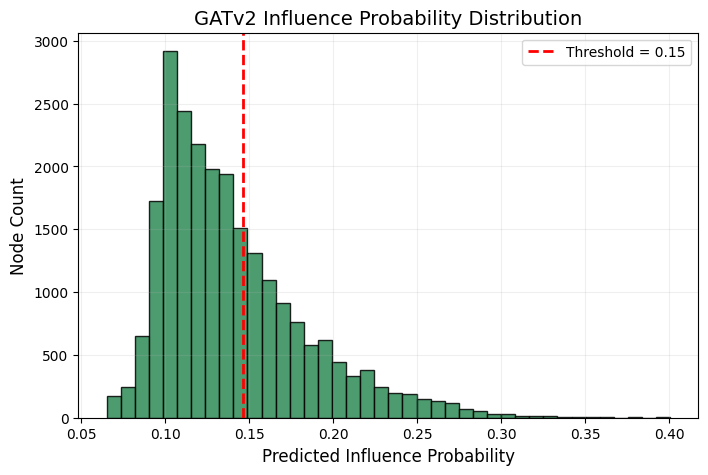

In [21]:
plt.figure(figsize=(8,5))
plt.hist(probs, bins=40, color='seagreen', edgecolor='black', alpha=0.85)
plt.axvline(best_thresh, color='red', linestyle='--', linewidth=2,
            label=f"Threshold = {best_thresh:.2f}")
plt.title("GATv2 Influence Probability Distribution", fontsize=14)
plt.xlabel("Predicted Influence Probability", fontsize=12)
plt.ylabel("Node Count", fontsize=12)
plt.legend()
plt.grid(alpha=0.2)
plt.show()